In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline
from pathlib import Path

import numpy as np
import pandas as pd

idx = pd.IndexSlice
import matplotlib.pyplot as plt
import seaborn as sns

## Data Ingestion

Note that some of this data was created in a different project: Gradient Booster Model for Factor Prediction

In [4]:
prices = pd.read_hdf('data/prices', 'prices') # for later ingesting

In [5]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3025636 entries, ('AMC', Timestamp('2013-12-18 00:00:00')) to ('HAYN', Timestamp('2021-12-23 00:00:00'))
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   high    float64
 1   close   float64
 2   low     float64
 3   open    float64
 4   volume  float64
dtypes: float64(5)
memory usage: 127.2+ MB


## Creating A 'Simple' Kelly Allocation Off Historical Data

In [6]:
close = prices['close'].unstack('symbol')

Create the monthly returns (as a percent change):

In [7]:
monthly_returns = close.loc['2014':'2021-11-30'].resample('M').last().pct_change()
stocks = monthly_returns.columns
monthly_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 95 entries, 2014-01-31 to 2021-11-30
Freq: M
Columns: 1000 entries, AMC to HAYN
dtypes: float64(1000)
memory usage: 742.9 KB


Take a 10 ticker sample to simplify the visualizations for this example. Limit the timeframe as well

In [8]:
sample = monthly_returns.sample(n=5,axis=1)
sampleindex = sample.columns

In [9]:
sample = sample.loc['2015':]

In [10]:
sample.info() # Make sure data is non-null

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 83 entries, 2015-01-31 to 2021-11-30
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CCOI    83 non-null     float64
 1   PRG     83 non-null     float64
 2   SLCA    83 non-null     float64
 3   INGN    83 non-null     float64
 4   BLKB    83 non-null     float64
dtypes: float64(5)
memory usage: 3.9 KB


In [11]:
sample

symbol,CCOI,PRG,SLCA,INGN,BLKB
date,,,,,
2015-01-31,0.047188,0.035656,-0.019074,-0.024546,0.010402
2015-02-28,-0.009174,-0.058436,0.286111,0.086601,0.038664
2015-03-31,-0.037854,-0.050319,0.098735,-0.037895,0.043612
2015-04-30,-0.009624,0.200992,0.048863,0.148484,0.066484
2015-05-31,-0.102029,0.030292,-0.174029,0.017420,0.014447
...,...,...,...,...,...
2021-07-31,0.009364,-0.090588,-0.126298,0.224029,-0.068434
2021-08-31,-0.064811,0.081106,-0.130693,-0.257992,-0.022992
2021-09-30,-0.023974,-0.112215,-0.089977,-0.272005,0.009471


Create variance:

In [12]:
SampleVar = sample.var()

## Applying Kelly Formula with continuous approximation:

For a variable where $E(X) = m$ and $Var(X) = s^2$. With initial capital $V_{0}$ betting fraction $f$, and return per unit of X, the result is:

$ V(f) = V_{0}(1 + (1-f)r+fX)= V_{0} (1+r+f(X-r))$, where r is the rate of retrun on the remaining capital. Then:

$ g(f) = E(G(f)) = E(ln(V(f)/V_{0}))= E (ln(1+r+f(X-r))) = 0.5ln(1+r+f(m-r+s))+0.5ln(1+r+f(m-r-s))$

Now subdivide the time interval into n equal independent steps, keeping the same drift and the same total variance. So $m$, $s^2$, and $r$ are replaced by $m/n$, $s^2/n$ and $r/n$. We have $n$ independent $X_{i} , i=1,...,n$ where the probability of both negative and positive outcomes about the mean is even, then:

$V_{n}(f)/V_{0} = \prod\limits_{i=1}^{n} (1+(1-f)r+fX_{i})$ and taking $E(log())$ of both sides will give $g(f)$. Expanding this to a power series will lead to a simplification (when bounded to infinity) of: $g_{\infty}(f) \equiv r + f(m-r) - s^2 f^2/2$

Plugging in the computed mean and variance for the ticker BHLB:

In [13]:
# Change to ticker in sample
m = sample['PRG'].mean()
v = SampleVar['PRG']

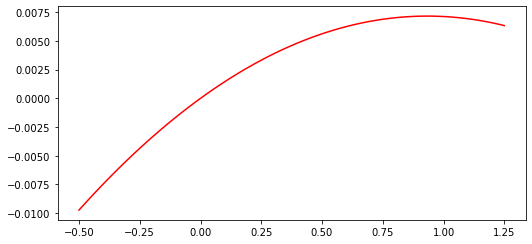

In [14]:
# 100 linearly spaced numbers
x = np.linspace(-0.5,1.25,100)

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

r=0 # set riskfree to 0, not very important for this example

def g(x):
    return r + x*(m-r) - (v)*(x**2)/2

plt.plot(x, g(x), color='red')

plt.show()


In [15]:
m/v

0.933024480899014

Here we can see the formula is a parabola, meaning maximizing the growth rate is a very simple solution, just taking the derivative and finding the maximum, which very simply becomes $f = mean/variance$, which is ~ 0.9 in this case.  

## Kelly for a Portfolio of Securities

Now moving into a balanced portfolio fraction $f_{0}$ and n risky assets with portfolio fraction $f _{1} ,...,f_{n}$, with the same descriptive varaibles as before.  If $\Sigma=(s_{i,j}$) with $i , j  = 1, 2,..., n$ is the variance-covariance matrix and $M = (m_{1},m_{2},...,m_{n})^T$ is the row vector of the expected returns for the n assets.

The expression of the prortfolio's capital after one time step:
  $ f_{0}r+\sum\limits_{i=1}^{n} f_{i} m_{i}$ where they are the fractions and returns on the ith asset. In matrix form it looks like: $r + F^T(M-R)$ where R is the column vector $(r,r,...,r)^T$ of length $n$. And we also have $s^2=F^TCF$. We have arrived at a similar quadratic maximization problem.

Interestingly, using this and solving the simultaneous equations of $\nabla g_{\infty}/\nabla f_{i} = 0, i = 1,...,n$ you get the solution of $F^* = \Sigma^{-1}[M-R]$. Which, if all securities are uncorrelated, $\Sigma$ will be diagonal and we will have the quadratic maximization solution for all the securities of $f_{i} = (m_{i}-r)/s_{i}^2$ (which if risk-free rate is zero will just be mean/variance).

In [16]:
# Using the sample variance from before
SampleMean = sample.mean()
UnCorrK = SampleMean/SampleVar

In [17]:
print(UnCorrK)

symbol
CCOI    2.140504
PRG     0.933024
SLCA    0.273474
INGN    0.489711
BLKB    1.707285
dtype: float64


Note that the Kelly solution here provides negative solutions as well as ones that are greater than 1 (or less than -1). Negative would mean you would be shorting those positions, and greater than 1 would mean taking leverage on the positions. 

## Kelly with Correlation

Recall the unconstraied correlated solution (with 0 risk free rate) is given by: $F = \hat{\Sigma} ^{-1} \hat{m}$ where $\hat{\Sigma}$ and $\hat{r}$ are the estimations of variance-covariance matrix and returns. Note that $\hat{\Sigma} ^{-1}$ is the inverse of the cov-var matrix, which is known as the precision matrix or the concentration matrix. This introduces the contsratin that ${\Sigma} ^{-1}$ must exist, which means the determinant of ${\Sigma}$ must not be 0. 

So we have to compute the var-cov matrix:

In [18]:
cov = sample.cov()

In [19]:
# Show the variance-covariance for the assets in this example
cov.style.background_gradient(cmap='coolwarm')

symbol,CCOI,PRG,SLCA,INGN,BLKB
symbol,,,,,
CCOI,0.005569,-0.000906,0.000680,0.001541,0.000968
PRG,-0.000906,0.016448,0.004914,0.000699,0.002774
SLCA,0.000680,0.004914,0.048855,0.005291,0.007394
INGN,0.001541,0.000699,0.005291,0.023208,0.001874
BLKB,0.000968,0.002774,0.007394,0.001874,0.005664


The diagonal for this matrix is the variance for each stock, and the covariances are the other cells. 

In [20]:
precision_matrix = pd.DataFrame(inv(cov), index=sampleindex, columns=sampleindex)

In [21]:
CorrK = precision_matrix.dot(SampleMean)
# sample.mean() is the mean vector

Here we can see the kelly allocations:

In [22]:
print(CorrK)

symbol
CCOI    2.071016
PRG     0.896216
SLCA    0.001290
INGN    0.258115
BLKB    0.827523
dtype: float64


But, the solution is not constrained. This is important for the model to work correctly, since leverage is incredibly risk and unrealistic. Running a portfolio without these conditions will not work. To overcome this situation, consider the maximization of the expected growth rate $g^*$. Notationally this corresponds to:

$ g^* = argmax_{F}[r + F^T(M-R)- 0.5(F^T \hat{\Sigma}F)]$ subject to: $\sum\limits_{i=1}^{n} f_{i} \le 1 ; 0 \le f_{i} \le 1$

To solve this, you need to compute a quadratic maximization problem. This is done here:

In [23]:
# pip install gurobipy
import gurobipy as gp
from gurobipy import GRB

In [93]:
def maxCK(mean,cov):
    ''' Maxamize the Kelly Fraction for correlated assets. Inputs are a mean vector and a covariance matrix.
        Note that covariance matrix must not be singular. '''

    m = gp.Model("opt1") # Create the model

    nstocks = len(mean)

    t = mean.to_numpy()
    c = cov.to_numpy()

    x = m.addMVar(shape=nstocks, lb=0.0, name="stock") # create weight vector

    m.Params.Threads=0.25 #reduce computer load
    m.Params.LogToConsole=0

    # Set the bounds for the weights to be above 0 and less than 1
    m.addConstr(x>=0, name='above 0') 
    m.addConstr(x<=1, name='below 1')

    # Make sure weights sum to 1 (fully invested portfolio)
    m.addConstr(x.sum()==1, name = 'equals 1')

    # This equation 
    m.setObjective (x@t - 0.5*(x@c@x), GRB.MAXIMIZE)
    m.optimize()
    pos = np.array([m.getVars()[i].x for i in range(len(m.getVars()))])
    return pos

In [80]:
def CorK(x):
    ''' Create a DataFrame for correlated Kelly allocations. Uses quadratic program created from before (maxCK).'''
    test= x.reset_index(drop=True)
    list = []
    idx = x.columns
    means = x.rolling(12).mean() # Create rolling means for the assets
    for i, r in test.iloc[12:].iterrows():
        m = means.iloc[i]
        cov = x.iloc[i-12:i].cov() # Create the covariance matrix
        k = maxCK(m,cov) # Calculate the optimal allocations
        k = pd.Series(k, index = idx)
        list.append(k)
    return pd.DataFrame(list)      


In [84]:
def UnCorK(x):
    test= x.reset_index(drop=True)
    list = []
    means = test.rolling(12).mean()
    vars = test.rolling(12).var()
    for i, r in test.iloc[12:].iterrows():
        var = vars.iloc[i]
        mean = means.iloc[i]
        k = mean/var
        list.append(k)
    x = pd.DataFrame(list)
    x.reset_index(drop=True, inplace=True)
    return(x)


In [85]:
# computationally taxing WARNING
corrkellys = CorK(sample) 

In [106]:
# Put constraints onto the uncorrelated case
uncorrkellys = UnCorK(sample)
uncorrkellys[uncorrkellys<0]=0 #normalization 
uncorrkellys = uncorrkellys.div(uncorrkellys.sum(axis=1), axis=0)    

In [30]:
def kellyport(allocations,returns,v):
    # Computes the kelly portfolio (assuming constrained to sum to 1 and positive only)
    list = []
    for i, r in allocations.iloc[1:].iterrows():
        prev = allocations.iloc[i-1]
        change = prev * returns.iloc[i]
        s = change.sum() + 1
        if v<0:
            print('BUST')
            break
        v = s*v
        list.append(v)
    return pd.DataFrame(list)

In [31]:
def eqport(returns,v):
    # Computes a portfolio  for an equal-weighted portfolio.this is the benchmark case. 
    list = []
    l = len(returns.columns)
    for i, r in returns.iloc[1:].iterrows():
        prev = np.full(l,1/l)
        change = prev * returns.iloc[i]
        s = change.sum() + 1
        if v<0:
            print('BUST')
            break
        v = s*v
        list.append(v)
    return pd.DataFrame(list)

In [32]:
retper = sample.iloc[12:].reset_index(drop=True)

In [33]:
eq = eqport(retper,10000)

In [34]:
uK = kellyport(uncorrkellys,retper,10000)
corK = kellyport(corrkellys,retper,10000)

In [35]:
# Set index
tt = sample.iloc[13:].index

In [36]:
uK.set_index(tt, inplace=True)
corK.set_index(tt, inplace=True)
eq.set_index(tt, inplace=True)

In [37]:
print(uK.pct_change().mean())
print(corK.pct_change().mean())
print(eq.pct_change().mean())

0    0.018948
dtype: float64
0    0.019653
dtype: float64
0    0.014109
dtype: float64


So in terms of average growth rate, the equal weighted performs the worst, then comes the uncorrelated kelly, and the best performer is the correlated kelly implementation.

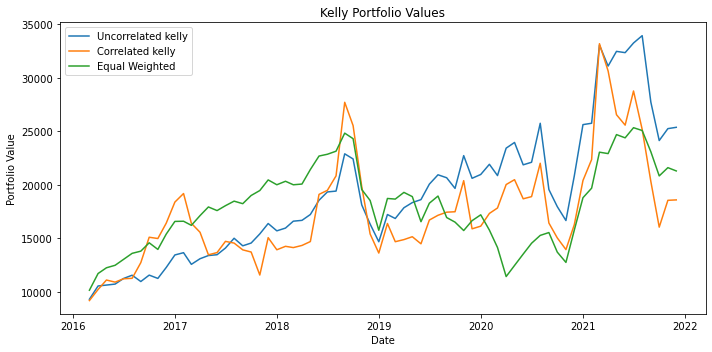

In [104]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_xlabel('Date')
ax.set_ylabel('Portfolio Value')
plt.plot(uK, label='Uncorrelated kelly')
plt.plot(corK, label='Correlated kelly')
plt.plot(eq, label = 'Equal Weighted')
ax.set_title('Kelly Portfolio Values')
ax.legend();

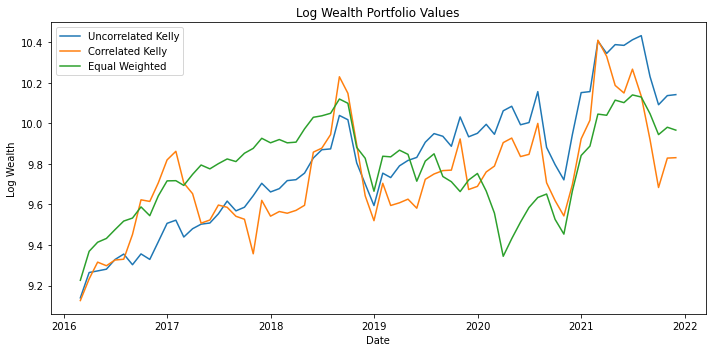

In [105]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title('Log Wealth Portfolio Values')
ax.set_xlabel('Date')
ax.set_ylabel('Log Wealth')
plt.plot(np.log(uK), label='Uncorrelated Kelly')
plt.plot(np.log(corK), label='Correlated Kelly')
plt.plot(np.log(eq), label = 'Equal Weighted')
ax.legend();

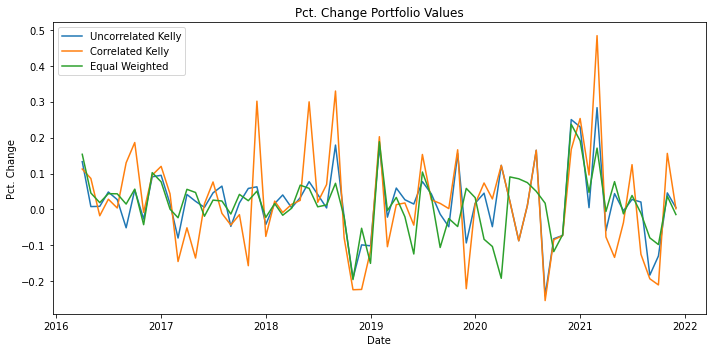

In [102]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title('Pct. Change Portfolio Values')
ax.set_xlabel('Date')
ax.set_ylabel('Pct. Change')
plt.plot(uK.pct_change(), label='Uncorrelated Kelly')
plt.plot(corK.pct_change(), label='Correlated Kelly')
plt.plot(eq.pct_change(), label = 'Equal Weighted')
ax.legend();

We can see that although the growth rate on average is greater for the kelly implemented portfolios, there are some issues with large drawdowns and the overall performance is only slightly better than the benchmark. There is also clear evidence that the correlated case is needed to ensure better performance. 

## Using the ML Predictions in Conjunction with Kelly Principle

In [41]:
lookahead = 21

In [42]:
def PredCorK(pred,ret):
    ''' Create a DataFrame for correlated Kelly allocations. Uses quadratic program created from before (maxCK).'''
    test= pred.reset_index(drop=True)
    window = ret.reset_index(drop=True)
    list = []
    idx = pred.columns
    for i, r in test.iterrows():
        m = test.iloc[i]
        cov = ret.iloc[67+i:70+i].cov() # Create the covariance matrix
        k = maxCK(m,cov) # Calculate the optimal allocations
        k = pd.Series(k, index = idx)
        list.append(k)
    return pd.DataFrame(list)      

In [43]:
predictions = pd.read_hdf('data/predictions.h5', f'lgb/test/{lookahead:02}').drop('y_test', axis=1)
predictions = (predictions.loc[~predictions.index.duplicated()]     
                   .iloc[:, :5]
                   .mean(1)
                   .sort_index()
                   .dropna())
predictions.index.names = ['ticker', 'date']
predictions = predictions.unstack('ticker').resample('M').last().dropna(how='all').dropna(axis=1)

In [44]:
p = predictions.sample(20,axis=1)
stocks = p.columns.tolist() # Creates list of tickers from the top and bottom predictions
ret = monthly_returns[stocks] # In order to compute the covariance matrix, get the same dates and isolate the data to the choosen tickers

## Run the Portfolios for Different Samples

In [46]:
for x in range(20):
    p = predictions.sample(20,axis=1)
    stocks = p.columns.tolist()
    returns = monthly_returns[stocks]
    PCK = PredCorK(p,returns)
    pt = CorK(returns.iloc[58:])
    matchedRet = returns.iloc[70:].reset_index(drop=True)
    MachineLearning = kellyport(PCK,matchedRet,10000)
    CorrKelly = kellyport(pt,matchedRet,10000)
    EqualWeighted = eqport(matchedRet, 10000)
    ii = ret.iloc[71:].index
    MachineLearning.set_index(ii, inplace=True)
    EqualWeighted.set_index(ii, inplace=True)
    CorrKelly.set_index(ii, inplace=True)
    EqualWeighted.rename(columns={0:f'EW{x}'},inplace=True)
    MachineLearning.rename(columns={0:f'ML{x}'},inplace=True)
    CorrKelly.rename(columns={0:f'CK{x}'},inplace=True)
    if x==0:
        EW = EqualWeighted
        ML = MachineLearning
        CK = CorrKelly
    else:
        EW = EW.join(EqualWeighted)
        ML = ML.join(MachineLearning)
        CK = CK.join(CorrKelly)

In [56]:
# Exports DataFrames to Excel
with pd.ExcelWriter('PortfolioFinal.xlsx') as writer:
    EW.to_excel(writer, sheet_name='Equal Weighted')
    ML.to_excel(writer, sheet_name='Machine Learning Mean')
    CK.to_excel(writer, 'Correlated Kelly')

In [ ]:
EW.mean(axis=1)
ML.mean(axis=1)
CK.mean(axis=1)

In [121]:
# Show the average monthly growth rates for the different techniques
print("Equal Weighted: " + str(EW.pct_change().mean().mean()))
print("Correlated Kelly: " + str(CK.pct_change().mean().mean()))
print("Machine Learning: " + str(ML.pct_change().mean().mean()))

Equal Weighted: 0.023468601879393414
Correlated Kelly: 0.03416815075219747
Machine Learning: 0.07432611175259318


In [113]:
CK.pct_change().mean().mean()

0.03416815075219747

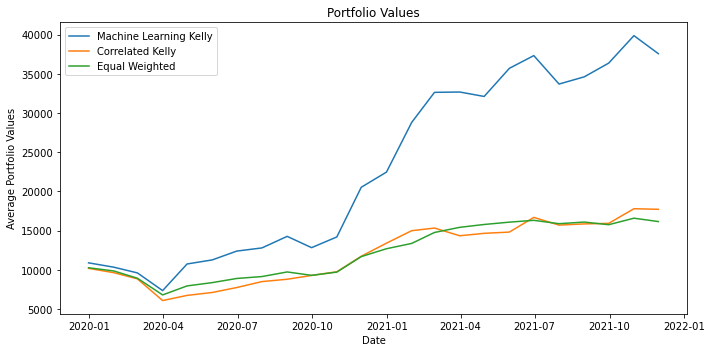

In [115]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title('Portfolio Values')
ax.set_xlabel('Date')
ax.set_ylabel('Average Portfolio Values')
plt.plot(ML.mean(axis=1), label='Machine Learning Kelly')
plt.plot(CK.mean(axis=1), label='Correlated Kelly')
plt.plot(EW.mean(axis=1), label = 'Equal Weighted')
ax.legend();

So, the results show that the kelly formula does in fact maximize the average growth. But, the formula tends to invest heavily in a single stock, causing larger drawdowns. This can be seen by the fact that the average performance of a kelly implementation ends up almost even(in terms of overall value) with the equal weighted portfolio. Also, the performance in drawdown periods is less than ideal. 
This result directly relates with the general discorse on the implementation of the Kelly Principle pointing to partial kelly systems (where things like the half kelly come in), espicially when you are using longer time frames like the monthly system tested in this example. It also points to implementing a system that provides greater position diversification systems. An interesting implementation would be adding some sort of risk parity system in conjunction with kelly betting, for example.  

The final addition of using a machine learning prediction for the mean rather than a rolling mean created much more interesting results. It faced the same issues of concentrated position sizing, but the drawdowns were less and the overall performance was almost double the equal weighted samples. 